除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，**AdaDelta算法没有学习率这一超参数**。

## 7.7.1 算法

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$\boldsymbol{g}_t$按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho < 1$（对应RMSProp算法中的$\gamma$），在时间步$t>0$，同RMSProp算法一样计算

$$\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用$\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：

$$ \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, $$

其中$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-5}$。接着更新自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. $$

最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. $$

可以看到，如不考虑$\epsilon$的影响，**AdaDelta算法跟RMSProp算法的不同之处在于使用$\sqrt{\Delta\boldsymbol{x}_{t-1}}$来替代学习率$\eta$**。

**注：为什么会有这样的想法，以及这样取代学习率会有什么作用？这几个问题有些想不到。**

## 7.7.2 从零开始实现

AdaDelta算法需要对每个自变量维护两个状态变量，即$\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [1]:
%matplotlib inline
import tensorflow as tf
import sys
import numpy as np
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l

features, labels = d2l.get_data_ch7()

In [6]:
def init_adadelta_states():
    s_w, s_b = np.zeros((features.shape[1], 1), dtype=float), np.zeros(1, dtype=float)
    delta_w, delta_b = np.zeros((features.shape[1], 1), dtype=float), np.zeros(1, dtype=float)   # 这一部分参数是什么？  是deta_X部分
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams, grads):
    rho, eps, i = hyperparams['rho'], 1e-5, 0
    for p, (s,delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (grads[i]**2)
        g = grads[i] * np.sqrt((delta + eps) / (s+ eps))
        p.assign_sub(g)
        delta[:] = rho * delta + (1-rho)*g*g
        i+=1

使用超参数$\rho=0.9$来训练模型。

loss: 0.246230, 1.217564 sec per epoch


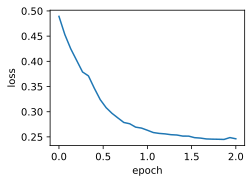

In [3]:
d2l.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

## 7.7.3 简洁实现

通过名称为`Adadelta`的优化器方法，我们便可使用Tensorflow2提供的AdaDelta算法。它的超参数可以通过`rho`来指定。

loss: 1.846843, 1.063888 sec per epoch


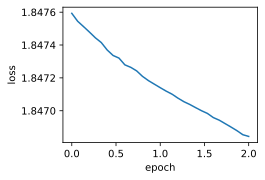

In [8]:
from tensorflow import keras
trainer = keras.optimizers.Adadelta(rho=0.9)   # learning_rate=0.01 这个是多余的，只需要一个参数就好了
d2l.train_tensorflow2_ch7(trainer, {'rho': 0.9}, features, labels)

## 小结

* AdaDelta算法没有学习率超参数，**它通过使用有关自变量更新量平方的指数加权移动平均的项来替代RMSProp算法中的学习率**。

**注：这句话总结到位了。**


## 参考文献

[1] Zeiler, M. D. (2012). ADADELTA: an adaptive learning rate method. arXiv preprint arXiv:1212.5701.

-----------

> 注：除代码外本节与原书此节基本相同，[原书传送门](https://zh.d2l.ai/chapter_optimization/adadelta.html)

